# VAR, VARMA, and VARMAX models for real GDP and real personal consumption forecasting

Importing libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

We will be looking at the United States Macroeconomic Dataset

In [3]:
#United states Macroeconomic Dataset
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


We will be predicting two time series, the real GDP (realgdp) and real personal consumption forecasting (realcons).

Let us now visualize how these two time-series look like




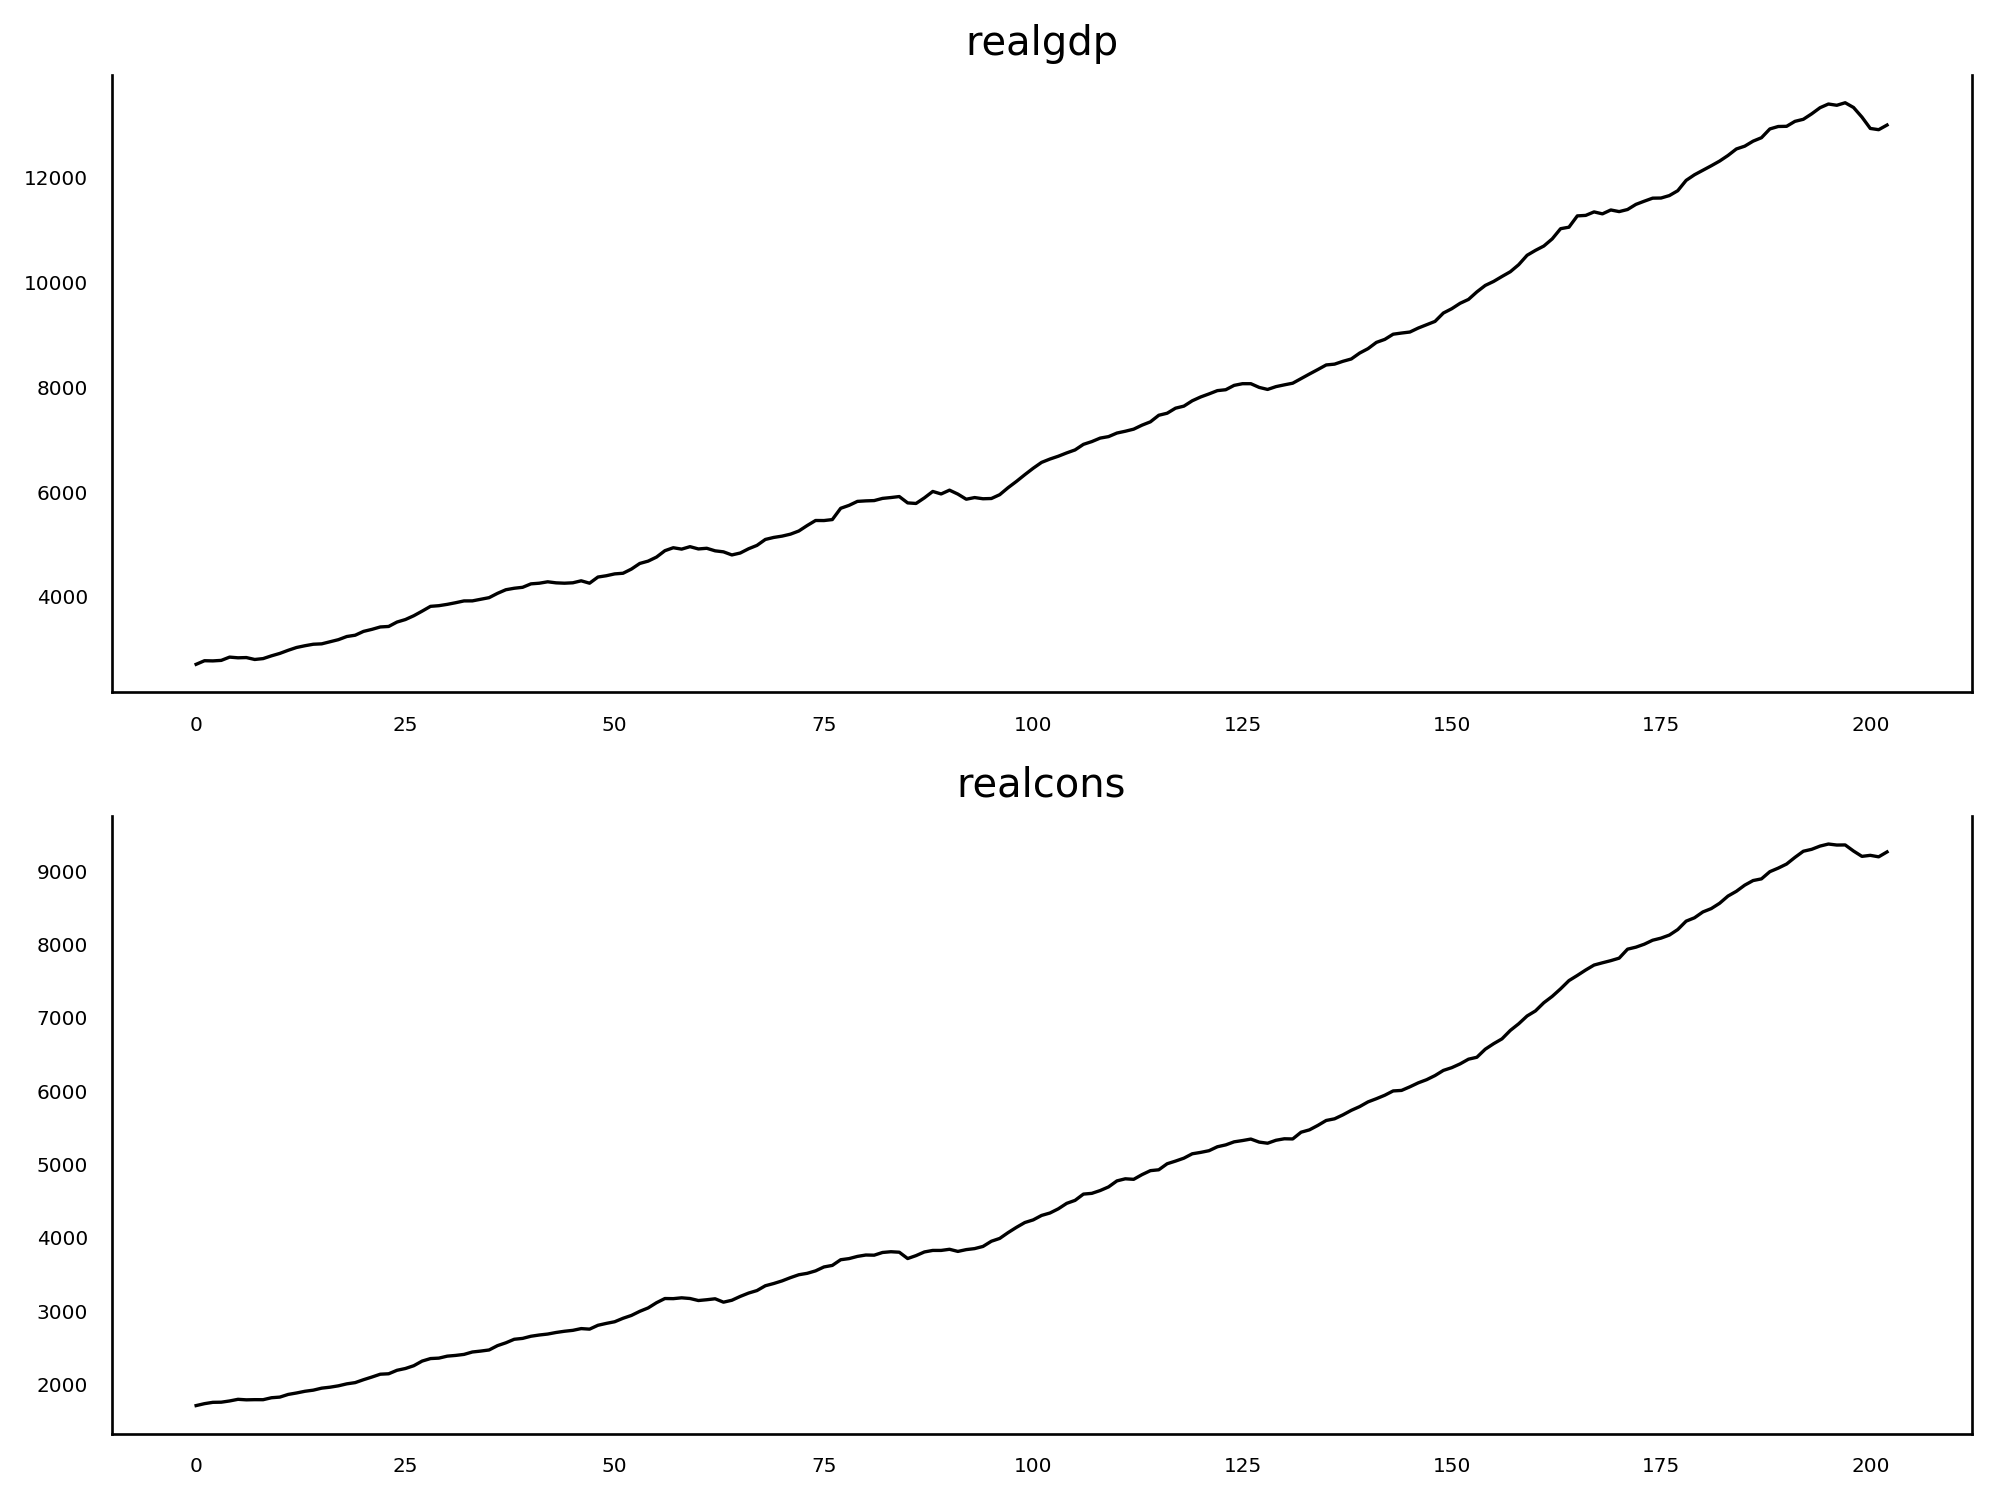

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, dpi = 240)

ax1.plot(macro_data['realgdp'], color = 'black', linewidth = 1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize = 6)

ax2.plot(macro_data['realcons'], color = 'black', linewidth = 1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)


The time-series show an upward trend. We need to make them stationary in order to proceed with the statistical analysis. This will then be followed by the ad-fuller statistical test to see whether we have actually achieved stationarity. 

In [7]:
#Both the time-series are obviously not stationary. Use adfuller test on set after differencing
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n--------------------')

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


realgdp
ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08

--------------------
realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


With p-values less than 0.05 for both the realgdp and realcons time-series, it can be seen that stationarity has been achieved. 

We will be writing an optimization function to perform a grid-search to find the most optimum order of the VAR (Variable AutoRegression) model. We choose Mean-Squared Error (MSE) as the metric for selection.

In [12]:
#Both Time-series are stationary

#Grid Search

def optimize_VAR(endog):
    """
    Returns a dataframe with parameters and corresponding MSE

    endog - observed time series
    """

    results = []

    for i in tqdm_notebook(range(15)):

        try:
            model = VARMAX(endog, order = (i, 0)).fit(dips = False)

        except:
            continue

        mse = model.mse

        results.append([i, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']

    result_df = result_df.sort_values(by = 'mse', ascending = True).reset_index(drop  =True)

    return result_df

In [13]:
endog = macro_data[['realgdp', 'realcons']]

result_df = optimize_VAR(endog)

result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse
0,13,1.466742e+05
1,11,1.498292e+05
2,8,1.502872e+05
3,12,1.527483e+05
4,10,1.637264e+05
5,9,1.652606e+05
6,6,1.711281e+05
7,5,1.827282e+05
8,4,1.985215e+05
9,3,3.792447e+05


Based on MSE, the optimum order of the model is 13. 

We will now take the optimum order and fit the data with the VAR model.

In [15]:
best_model = VARMAX(endog, order = (13, 0))
res = best_model.fit(disp = False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(13)   Log Likelihood               -1978.628
                               + intercept   AIC                           4071.257
Date:                     Mon, 20 Sep 2021   BIC                           4260.110
Time:                             18:05:55   HQIC                          4147.659
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.02, 0.00   Jarque-Bera (JB):           4.87, 4.96
Prob(Q):                        0.89, 0.96   Prob(JB):                   0.09, 0.08
Heteroskedasticity (H):         1.74, 2.56   Skew:                       0.3

Let us now look at the residual diagnostics for the VAR model to gauge how good the fit is to the actual data.

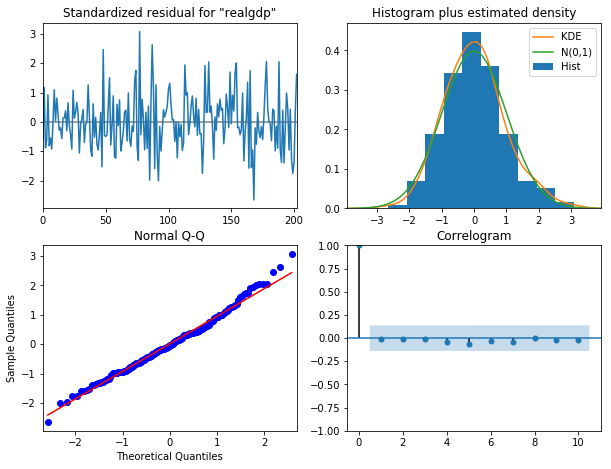

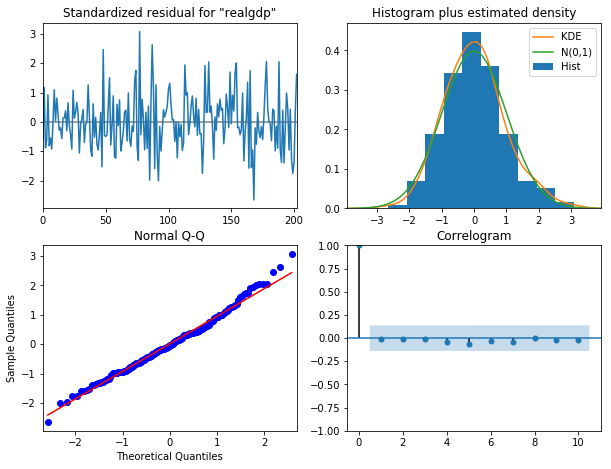

In [16]:
res.plot_diagnostics()

It can be seen that the residuals are very close to a normal distribution, showing that our model fits the data quite well.

Let's try to forecast the next 3 quarters

In [18]:
n_forecast = 3

predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)  #Three time steps into the future

,realgdp,realcons
204,13168.158028,9326.566136
205,13204.683471,9327.085377
206,13243.133515,9338.612224


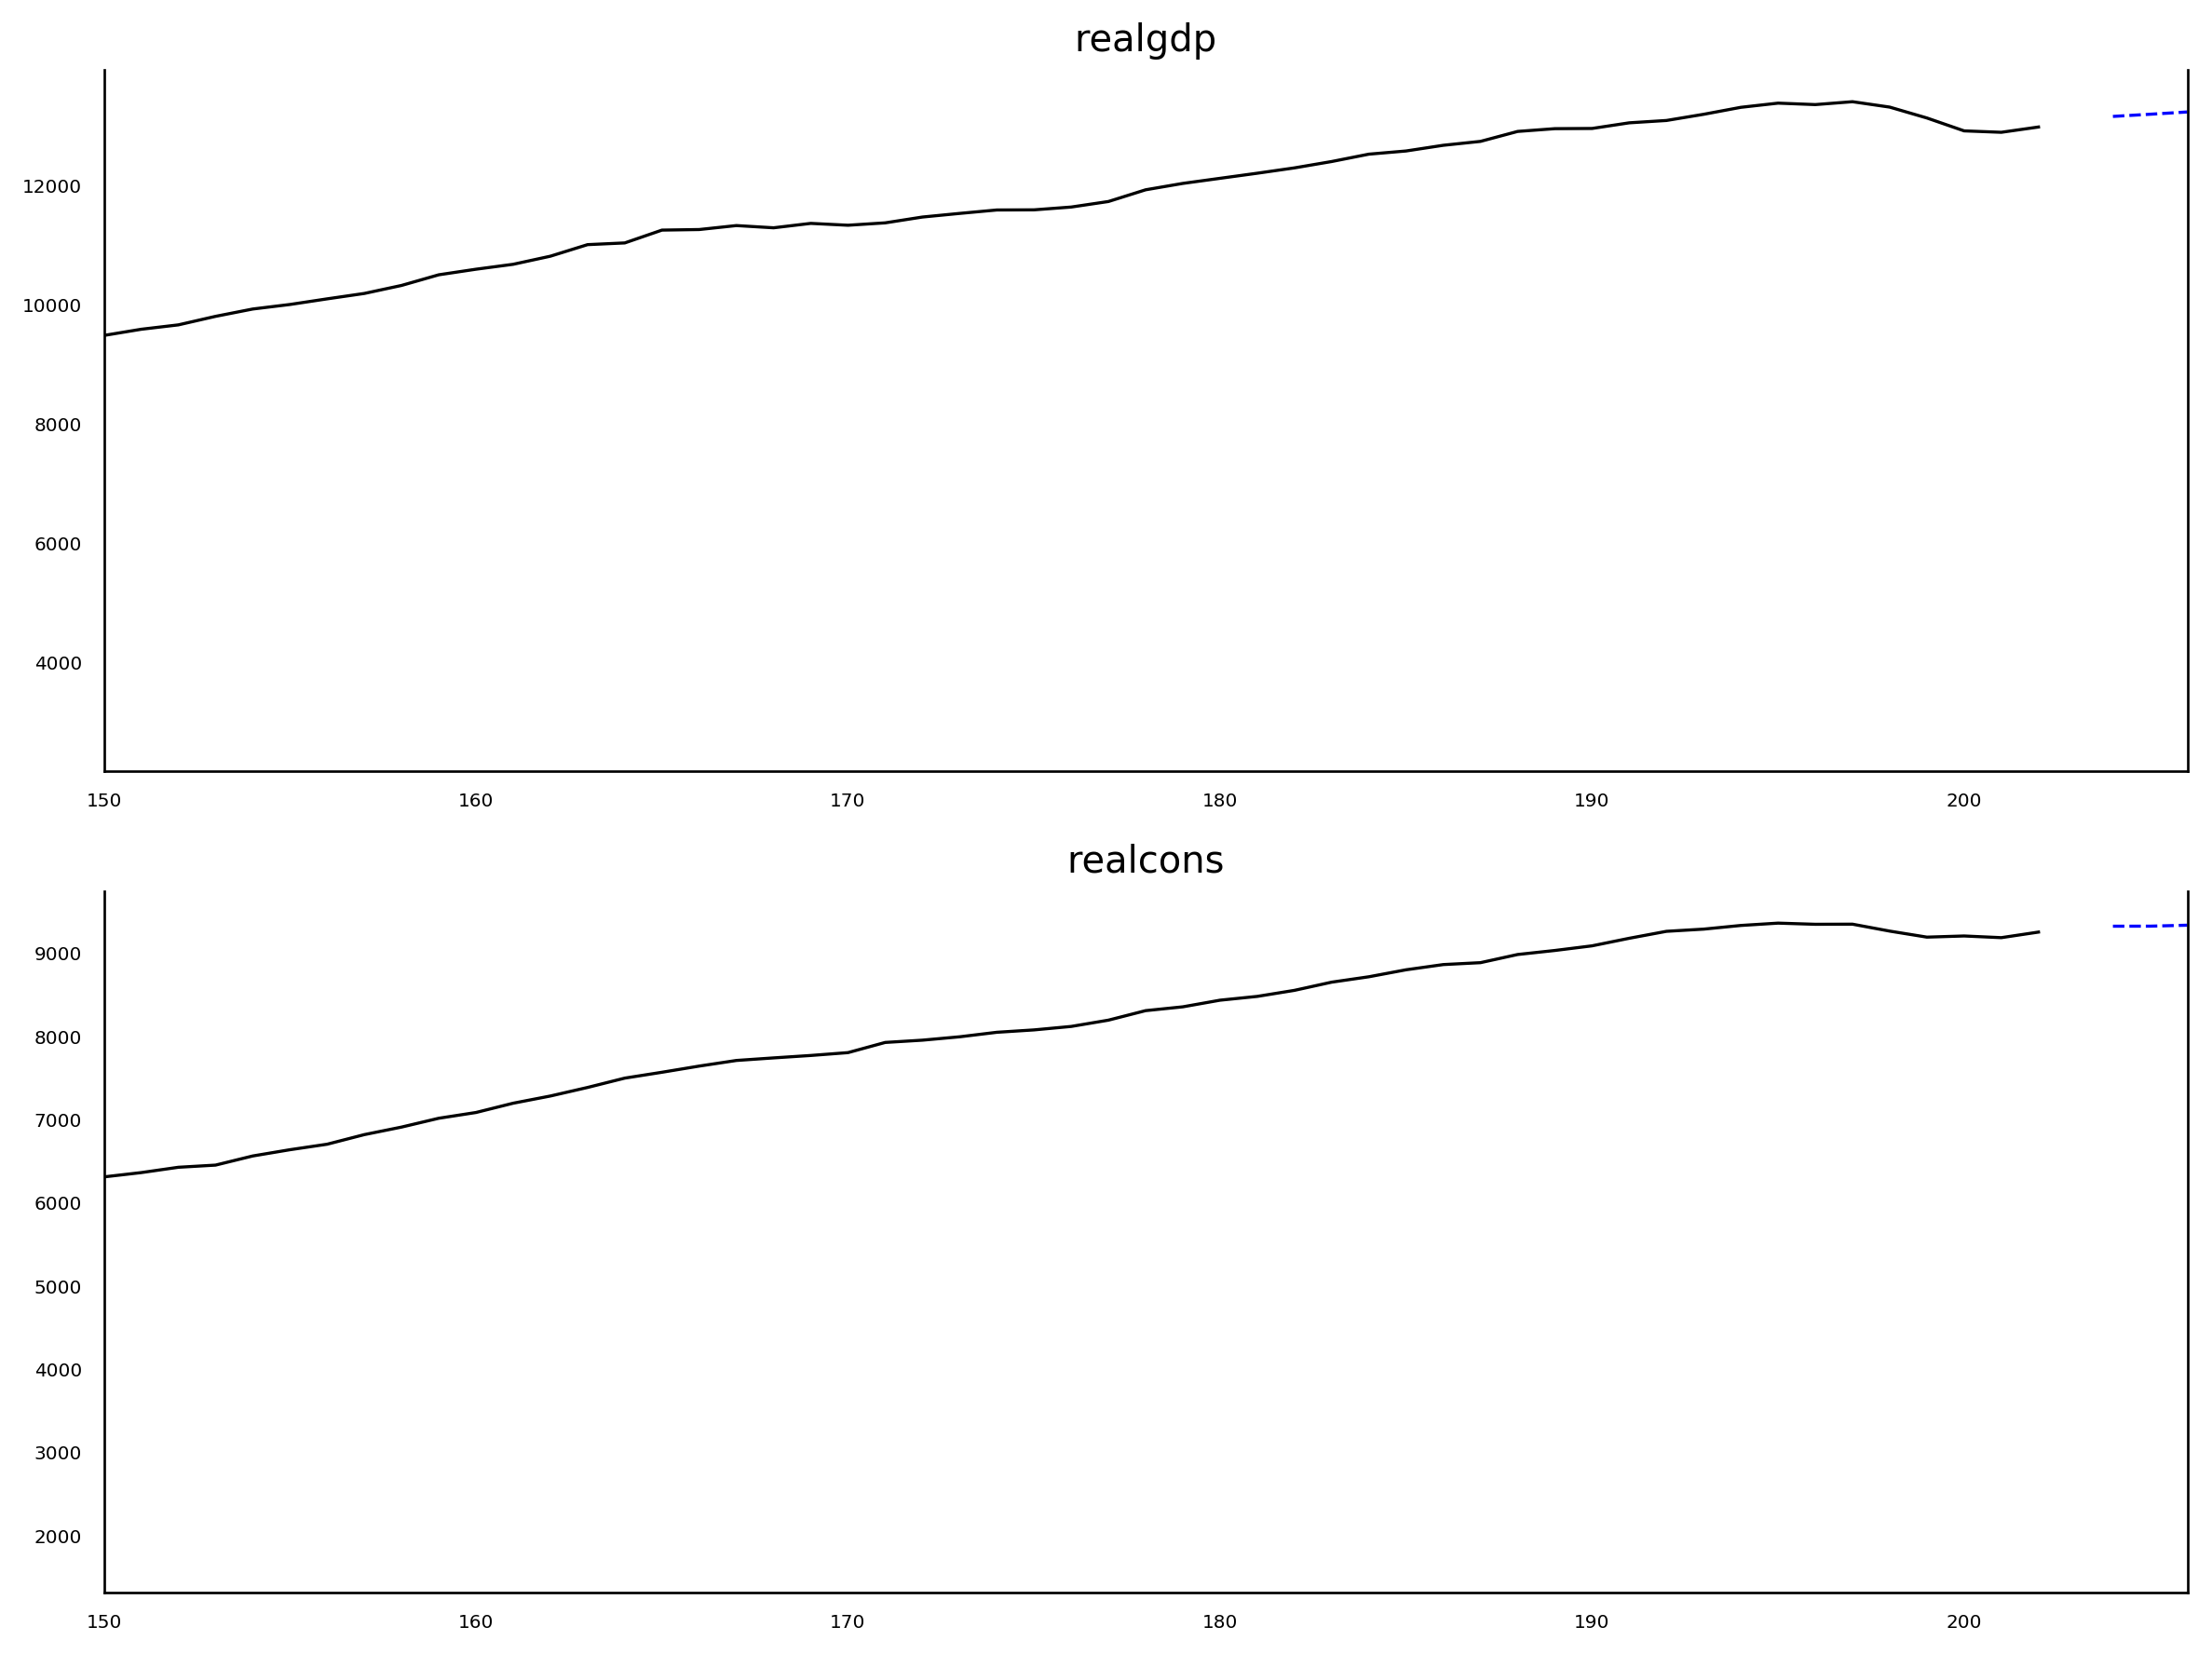

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, dpi = 240)

ax1.plot(macro_data['realgdp'], color = 'black', linewidth = 1)
ax1.plot(idx[-n_forecast:], 
            predict.predicted_mean['realgdp'][-n_forecast:],
             color = 'blue',
             ls = '--',
             linewidth = 1)

ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize = 6)

ax2.plot(macro_data['realcons'], color = 'black', linewidth = 1)
ax2.plot(idx[-n_forecast:], 
            predict.predicted_mean['realcons'][-n_forecast:],
             color = 'blue',
             ls = '--',
             linewidth = 1)

ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

plt.tight_layout()


It can be seen that our time-series prediction are good for the realgdp, but not as much for realcons.

We would like to test two hypothesis:

1. Does realgdp cause realcons?

2. Does realcons cause realgdp?

We will use the Granger causality tests to answer these questions. We will also do an order 1 differencing to make the time-series stationary with lag order 13.

In [21]:
print('realcons causes realgdp? \n')
print('----------------------------------')

granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [13]) #Granger causality test works only on stationary series , p = 13


print('\nrealgdp causes realcons?\n')
print('-------')
granger_1 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [13])

realcons causes realgdp? 

----------------------------------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=85.5708 , p=0.0000  , df=13
likelihood ratio test: chi2=70.5844 , p=0.0000  , df=13
parameter F test:         F=5.6420  , p=0.0000  , df_denom=162, df_num=13

realgdp causes realcons?

-------

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13
ssr based chi2 test:   chi2=32.3973 , p=0.0021  , df=13
likelihood ratio test: chi2=29.9021 , p=0.0049  , df=13
parameter F test:         F=2.1361  , p=0.0146  , df_denom=162, df_num=13


Based on the Granger Causality tests, both the hypothesis posed above are correct.

Now let us fit the time-series with the VARMA. We will write a VARMA optimization function to find the optimum (p,q) values that will fit the data. We will choose MSE as the metric for selection

In [4]:
#VARMA Starts

def optimize_VARMA(endog, parameters_list):
    """
    Returns a dataframe with parameters (p,q) and corresponding MSE

    endog - the observed variable

    parameter_list - list of (p,q) tuples
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order = param).fit(disp = False)

        except:
            continue

        mse = model.mse
        results.append([param, mse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'mse']

    result_df = result_df.sort_values(by = 'mse', ascending = True).reset_index(drop = True)

    return result_df

In [5]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0,4)

q = range(0,4)

parameters = product(p,q)

parameters_list = list(parameters)

result_df_VARMA = optimize_VARMA(endog, parameters_list)

result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(3, 1)",1.657274e+05
1,"(3, 2)",1.832809e+05
2,"(3, 3)",2.380651e+05
3,"(1, 1)",2.402511e+05
4,"(3, 0)",3.792447e+05
5,"(0, 1)",5.724883e+05
6,"(2, 1)",6.345681e+05
7,"(1, 2)",7.181966e+05
8,"(2, 2)",1.075738e+06
9,"(1, 3)",1.190475e+06


Based on MSE the optimum (p,q) values are (3,1)

We will now take the optimum parameter values and fit the data with the VARMA model.

In [7]:
best_model_VARMA  = VARMAX(endog, order = (3,1))

res_VARMA = best_model_VARMA.fit(disp = False)

print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                          VARMA(3,1)   Log Likelihood               -2000.987
                               + intercept   AIC                           4043.974
Date:                     Mon, 20 Sep 2021   BIC                           4113.551
Time:                             19:26:48   HQIC                          4072.122
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.53, 0.02   Jarque-Bera (JB):          3.46, 10.44
Prob(Q):                        0.47, 0.89   Prob(JB):                   0.18, 0.01
Heteroskedasticity (H):         2.48, 2.96   Skew:                       0.1

Let us now look at the residual diagnostics for the VARMA model to gauge how good the fit is to the actual data.

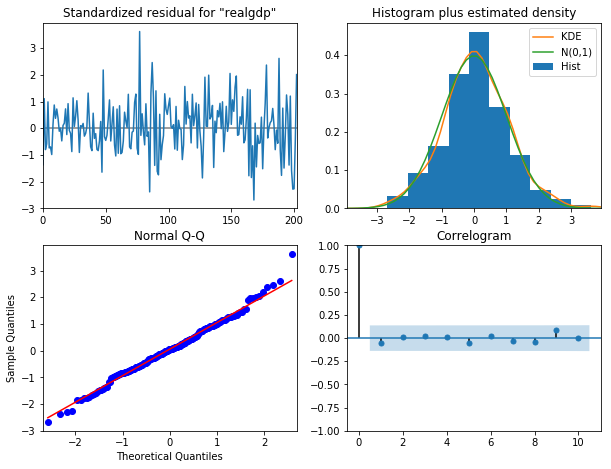

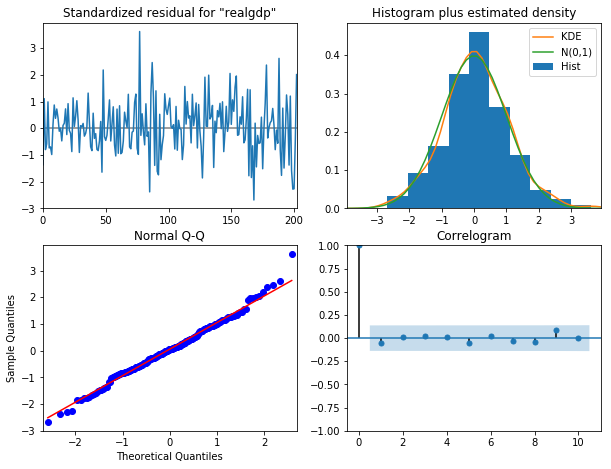

In [8]:
res_VARMA.plot_diagnostics()

It can be seen that the residuals are very close to a normal distribution, showing that our model fits the data quite well.

Let us try forecasting with the VARMA model for the next 3 quarters. 

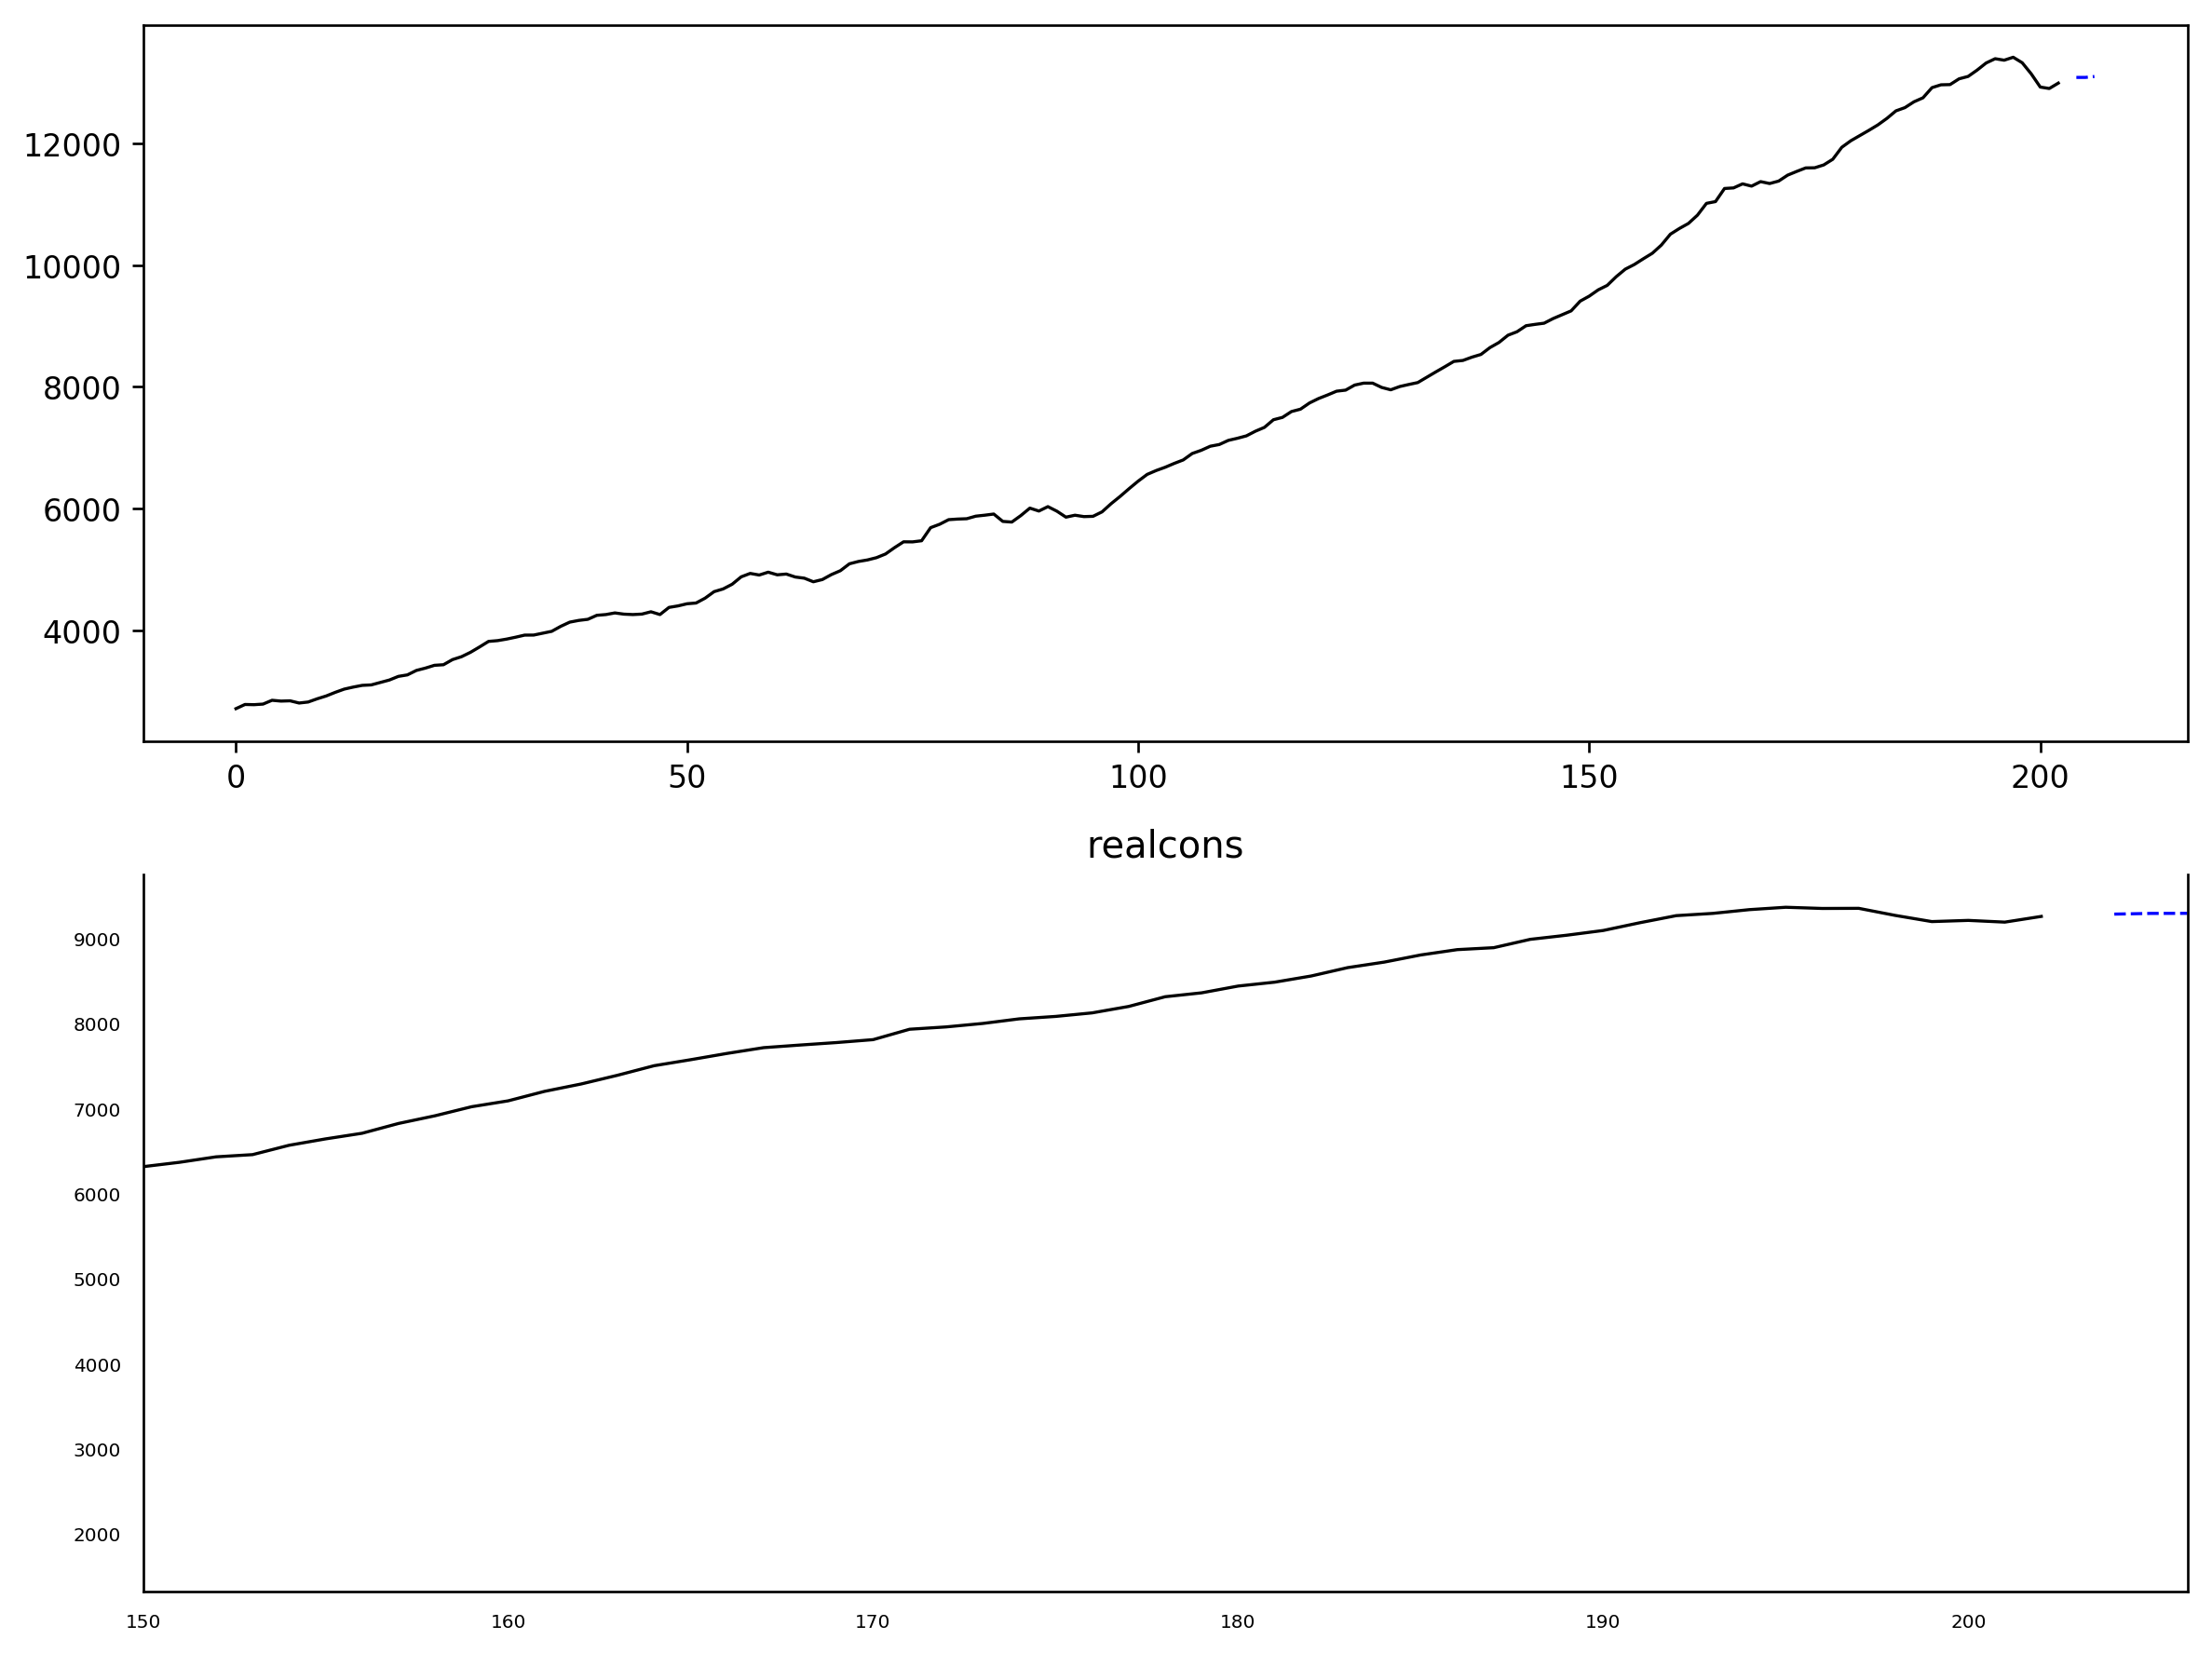

In [16]:
n_forecast = 3

predict = res_VARMA.get_prediction(end = best_model_VARMA.nobs + n_forecast)
idx  = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, dpi = 240)

ax1.plot(macro_data['realgdp'], color = 'black', linewidth = 1)
ax1.plot(idx[-n_forecast :],
            predict.predicted_mean['realgdp'][-n_forecast :],
            color = 'blue',
            ls = '--',
            linewidth = 1)

ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

ax2.plot(macro_data['realcons'], color = 'black', linewidth = 1)
ax2.plot(idx[-n_forecast :],
            predict.predicted_mean['realcons'][-n_forecast :],
            color = 'blue',
            ls = '--',
            linewidth = 1)

ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

plt.tight_layout()


It can be seen that both realgdp and realcons are getting reasonable predictions for the next three quarters.


Now let us fit the time-series with VARMAX model. We will write the VARMAX optimization function to find the optimum (p,q) values that fit the data. We will choose MSE as the metric for selection. 

In [18]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
    Returns a dataframe with (p,q)

    endog - the observed variables

    exog - the exogenous variables

    parameters_list - list of (p,q) tuples

    """

    results = []

    for param in tqdm_notebook(parameters_list):

        try:

            model = VARMAX(endog, exog, order = param).fit(disp = False)

        except:
            continue

        mse = model.mse

        results.append([param, mse])

    result_df = pd.DataFrame(results)

    result_df.columns = ['(p,q)', 'mse']

    result_df = result_df.sort_values(by = 'mse', ascending = True).reset_index(drop = True)

    return result_df

We will pass the year, quarter, realgdp, and realcons as the exogenous variables.

In [19]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(['year', 'quarter', 'realgdp', 'realcons'])

exog = macro_data[exog_cols][:200]

p = range(0, 4)
q = range(0, 4)

parameters = product(p,q)

parameters_list = list(parameters)

result_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)

result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(1, 3)",2317.216642
1,"(3, 3)",2322.696171
2,"(2, 3)",2342.558460
3,"(3, 2)",2363.898834
4,"(2, 2)",2395.878844
5,"(1, 2)",2405.007750
6,"(3, 1)",2465.104070
7,"(3, 0)",2519.680501
8,"(2, 1)",2538.998788
9,"(1, 0)",2559.286822


Based on MSE, the optimum (p,q) values are (1,3)

We will now take the optimum parameter values and fit the data with the VARMAX model.

In [21]:
best_model_VARMAX = VARMAX(endog, exog, order = (1,3))

res_VARMAX = best_model_VARMAX.fit(disp = False)

print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(3,3)   Log Likelihood               -1951.862
                               + intercept   AIC                           4001.725
Date:                     Mon, 20 Sep 2021   BIC                           4163.342
Time:                             20:30:35   HQIC                          4067.129
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             1.04, 0.12   Jarque-Bera (JB):           4.20, 3.53
Prob(Q):                        0.31, 0.73   Prob(JB):                   0.12, 0.17
Heteroskedasticity (H):         1.84, 2.25   Skew:                      0.06

Let us now look at the residual diagnostics for the VARMAX model to gauge how good the fit is to the actual data.

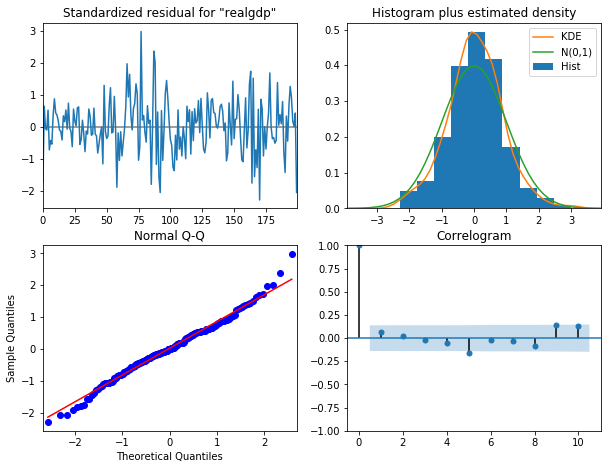

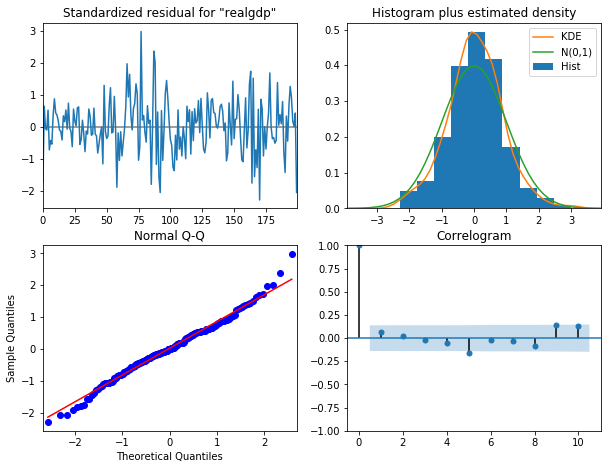

In [22]:
res_VARMAX.plot_diagnostics()

It can be seen that the residuals are very close to the normal distribution, showing that our model fits the data quite well.

Let us try forecasting with the VARMAX model for the next 3 quarters

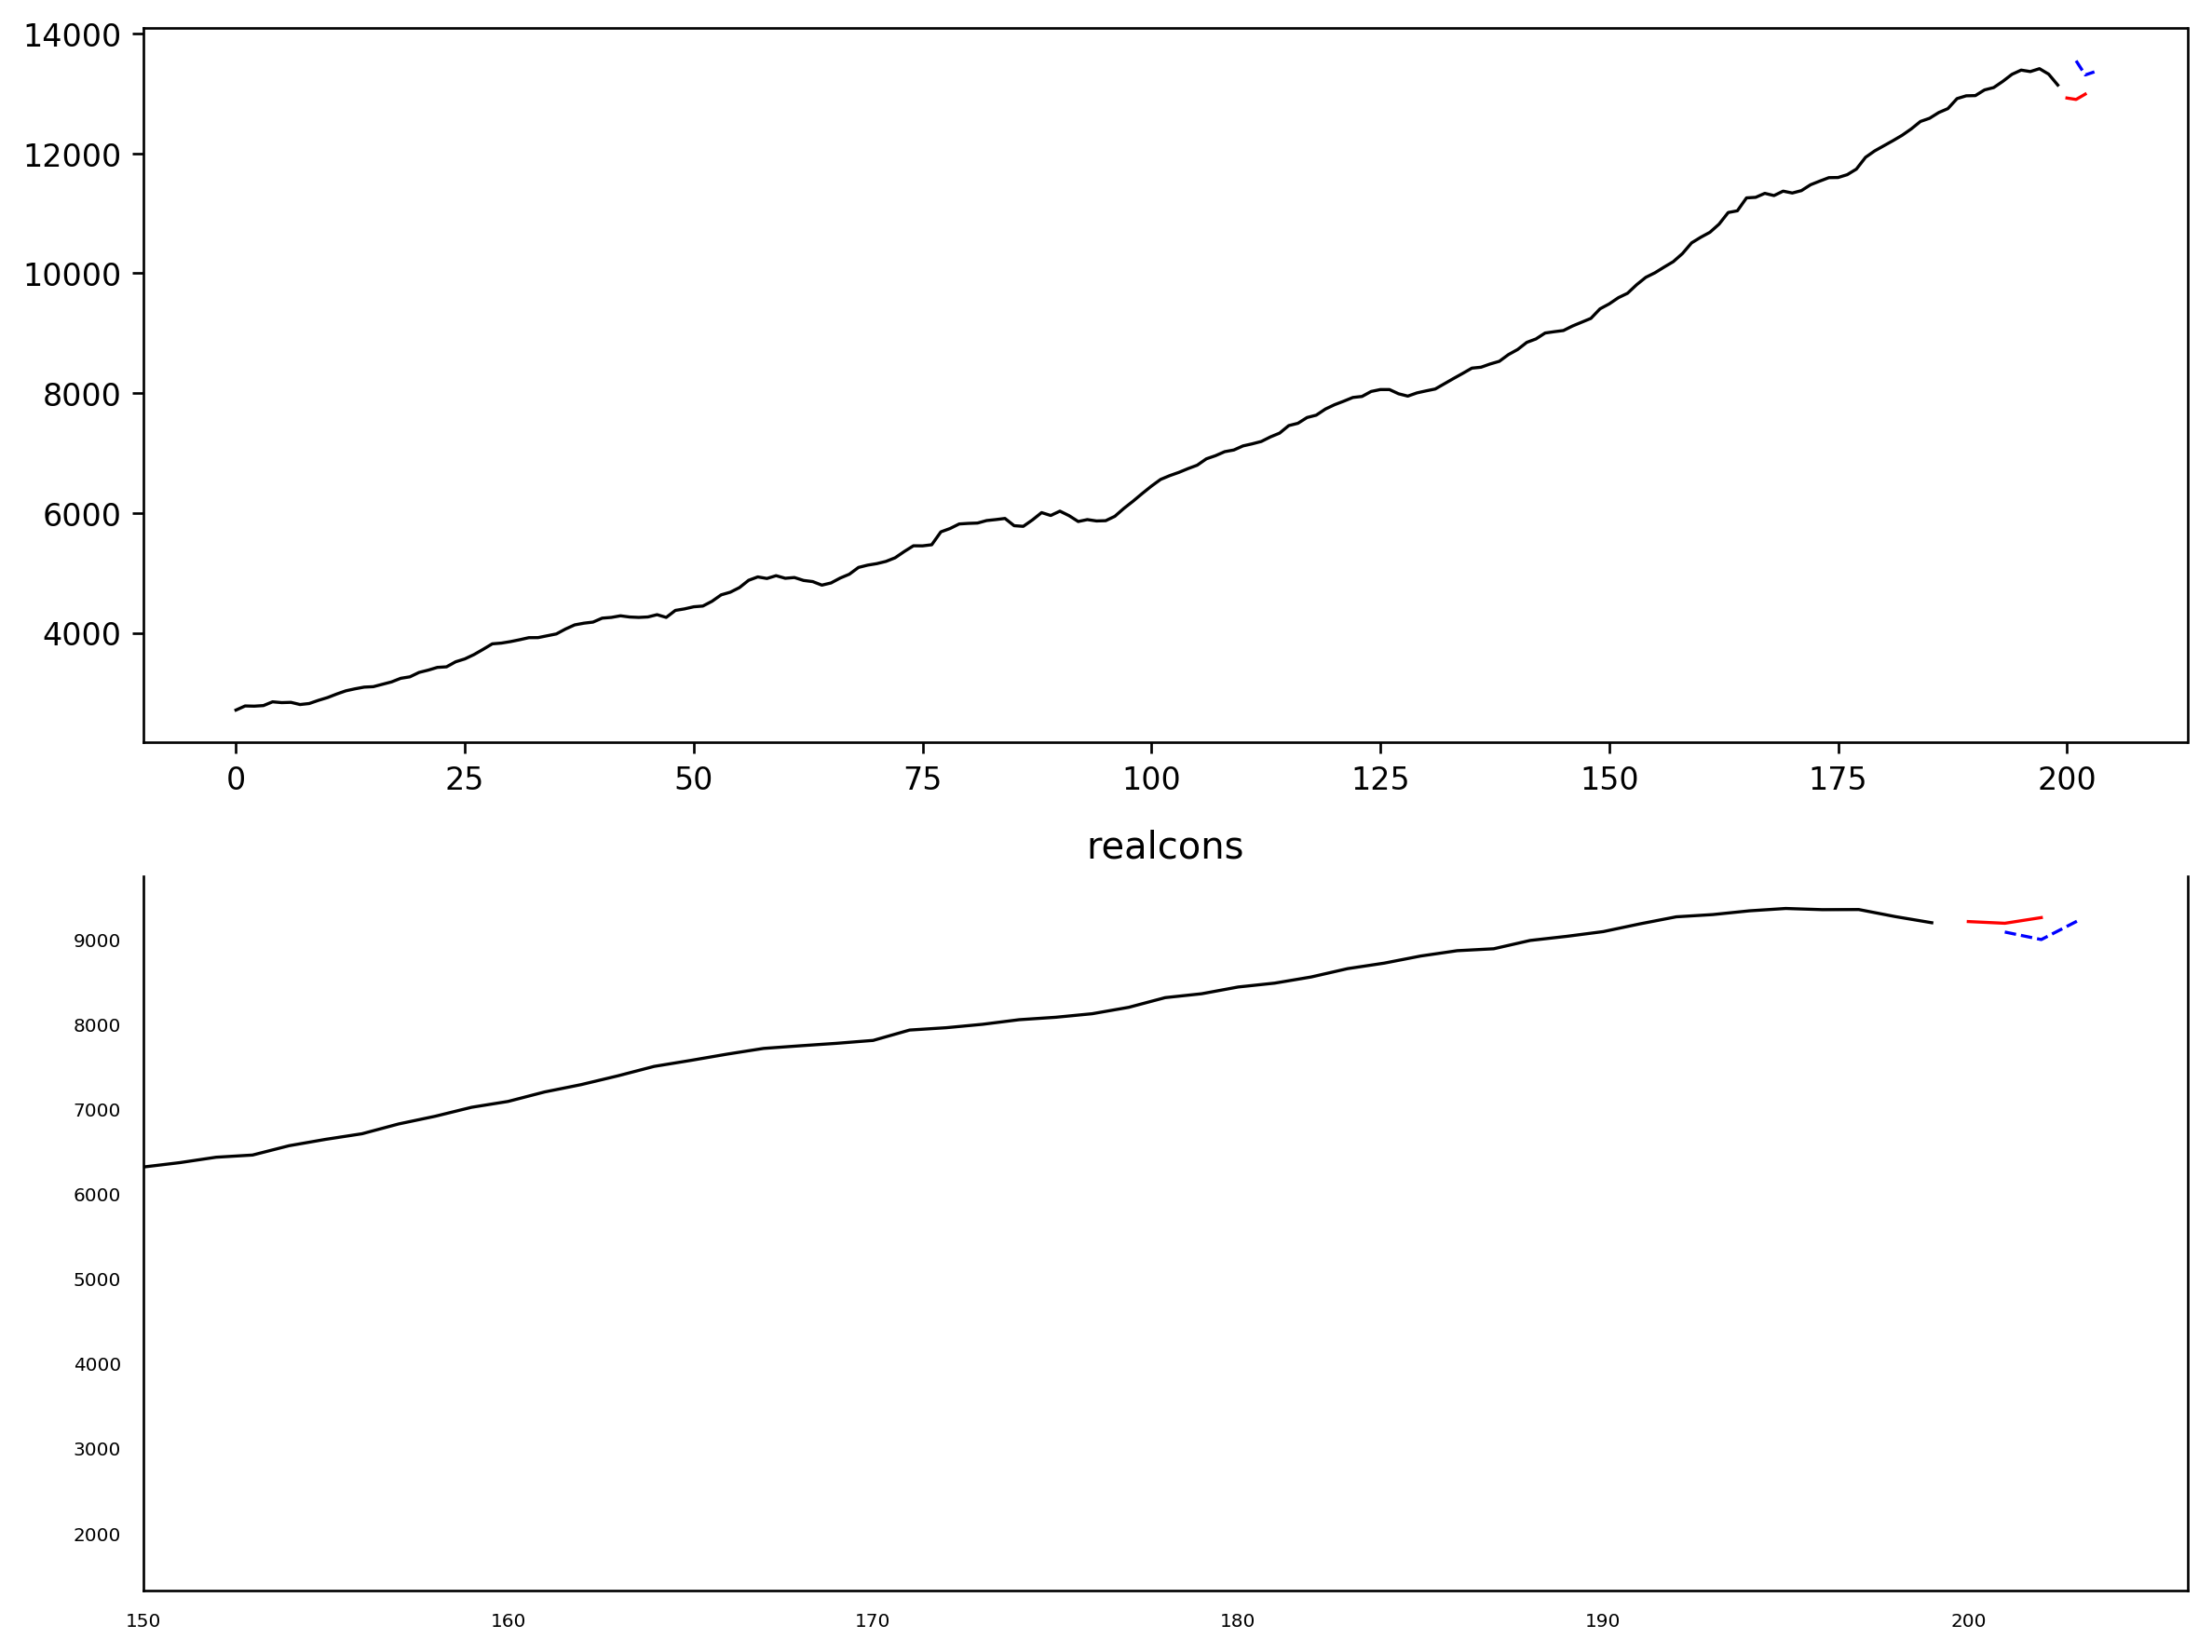

In [24]:
n_forecast = 3

predict = res_VARMAX.get_prediction(
    end = best_model_VARMAX.nobs + n_forecast,
    exog = exog.iloc[-4:]
)

idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, dpi = 240)

ax1.plot(macro_data['realgdp'][:200], color = 'black', linewidth = 1)
ax1.plot(macro_data['realgdp'][200:], color = 'red', linewidth = 1)
ax1.plot(idx[-n_forecast :],
            predict.predicted_mean['realgdp'][-n_forecast :],
            color = 'blue',
            ls = '--',
            linewidth = 1)

ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

ax2.plot(macro_data['realcons'][:200], color = 'black', linewidth = 1)
ax2.plot(macro_data['realcons'][200:], color = 'red', linewidth = 1)
ax2.plot(idx[-n_forecast :],
            predict.predicted_mean['realcons'][-n_forecast :],
            color = 'blue',
            ls = '--',
            linewidth = 1)

ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize = 6)

plt.tight_layout()



Here red predicts the actual curves and blue are the prediction. For the realcons time series, they are quite close. While for the realgdp time series, they are not.